# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Import modules

In [1]:
import pickle
import numpy as np
import numpy.random as rand
import random as rd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns
from sklearn.utils import shuffle
# import random as rd
import tensorflow as tf
from sklearn.utils import shuffle
import pandas as pd
import datetime
import os

## Create mapping dictionary from csv file

In [2]:
import csv
with open('signnames.csv') as map_file:
    reader = csv.reader(map_file)
    
    map_dict={}
    for row in reader:
        map_dict[row[0]] = row[1:]

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "../traffic-signs-data/train.p"
validation_file = "../traffic-signs-data/valid.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
import numpy as np

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_valid = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_test.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.max(y_test)+1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [6]:
explore_data = True

## Plot traffic sign images

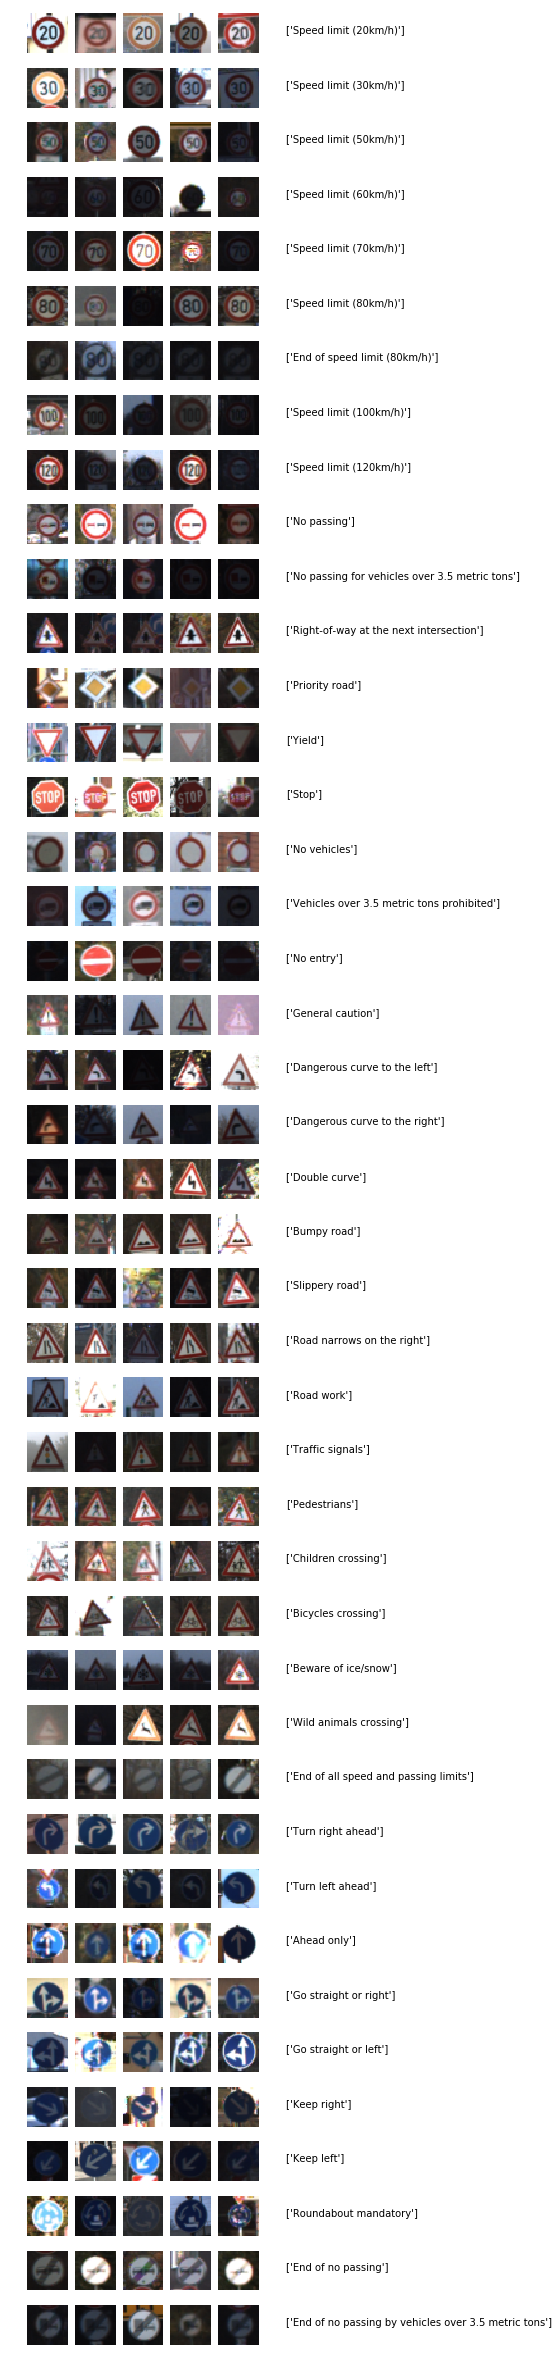

In [7]:
if explore_data:
    n_rows = n_classes
    n_cols = 5

    number_of_images = n_rows*n_cols
    figure, axis = plt.subplots(n_rows, n_cols+1, figsize=(5, 43))
    # figure.subplots_adjust(hspace = 1, wspace = .1)

    for i_row in range(n_rows):
        idx_spc = np.where(y_train==i_row)
        for i_col in range(n_cols):
            idx = np.random.randint(idx_spc[0][0],idx_spc[0][-1])
            image = X_train[idx,:,:,:]
            axis[i_row,i_col].axis('off')
            axis[i_row,i_col].imshow(image)
            if i_col==n_cols-1:
                axis[i_row,i_col+1].axis('off')
                axis[i_row,i_col+1].text(.5,.5,map_dict[str(i_row)],ha='left')
                

## Plot counts

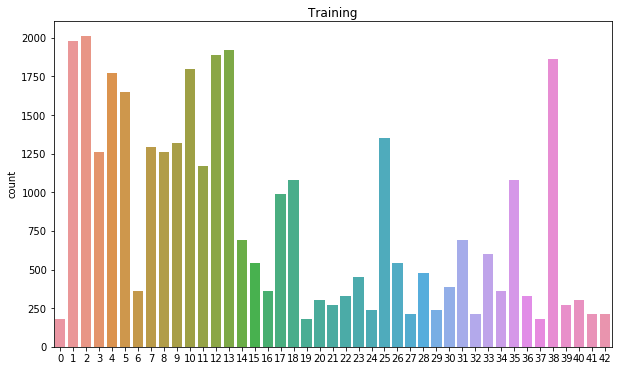

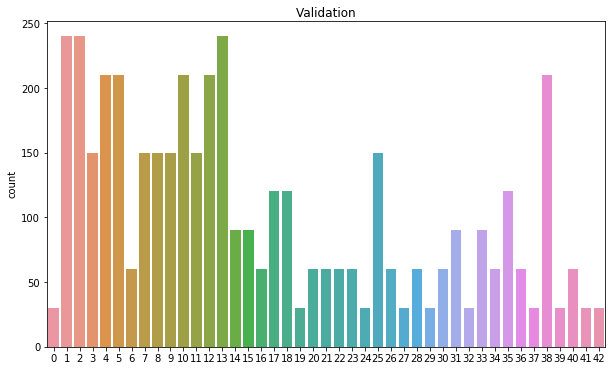

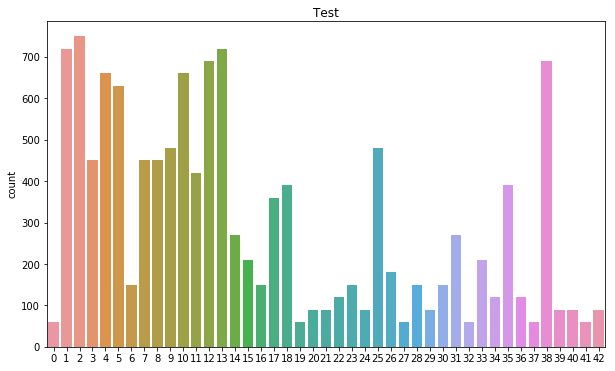

In [8]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,6))
p = sns.countplot(y_train)
plt.title('Training')
# # p.set_xticklabels(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_valid)
plt.title('Validation')
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_test)
plt.title('Test')
plt.show()

# # fig, ax = plt.subplots(figsize=(10,6))
# sns.countplot(np.hstack([y_train,y_valid,y_test]),ax=ax)
# plt.title('Total # of images per class')
# plt.xlabel('Traffic sign code')


## Augment data (replicate)

In [9]:
class_id, class_size = np.unique(y_train, return_counts=True)
max_class_size = np.max(class_size)

# target_class_size = max_class_size
target_class_size = 3000
# target_class_size = int(max_class_size*(1 + 0.5))

X_train_bal = np.zeros((n_classes*target_class_size,32,32,3),dtype=np.uint8)
y_train_bal = np.zeros((n_classes*target_class_size),dtype=int)

start = 0
for i in range(n_classes):
    # fill new array with old data
    class_inds = np.where(y_train==i)
    X_train_class = X_train[class_inds]
    y_train_class = y_train[class_inds]
#     import pdb; pdb.set_trace()
    prop = target_class_size/class_size[i] # how often the existing data fits into the augmented array
    rest = target_class_size%class_size[i]
    # if existing data fits more than 1x in augm array
    if prop>1:
        # fill up with integer multiple
#         import pdb; pdb.set_trace()
        X_train_bal[start:start+class_size[i]*int(prop)] = np.tile(X_train_class,(int(prop),1,1,1))
        y_train_bal[start:start+class_size[i]*int(prop)] = np.tile(y_train_class,int(prop))
        # fill up rest
#         rand_inds = rand.randint(class_inds, rest)
        X_train_bal[start+class_size[i]*int(prop):start+target_class_size] = X_train_class[0:rest]
        y_train_bal[start+class_size[i]*int(prop):start+target_class_size] = y_train_class[0:rest]
        
#         X_train_bal[start+class_size[i]*int(prop):start+target_class_size] = rd.sample(X_train_class.tolist(), 
#                                                                                             rest)
#         y_train_bal[start+class_size[i]*int(prop):start+target_class_size] = rd.sample(y_train_class.tolist(), 
#                                                                                             rest)
    
    if prop==1:
        X_train_bal[start:start+class_size[i]*int(prop)] = X_train_class
        y_train_bal[start:start+class_size[i]*int(prop)] = y_train_class
        
    if prop<1:
        print('something went wrong...')
    
    # update start value for next class
    start += target_class_size

        

## Bypass augmentation

In [10]:
# X_train_bal = np.copy(X_train)
# y_train_bal = np.copy(y_train)

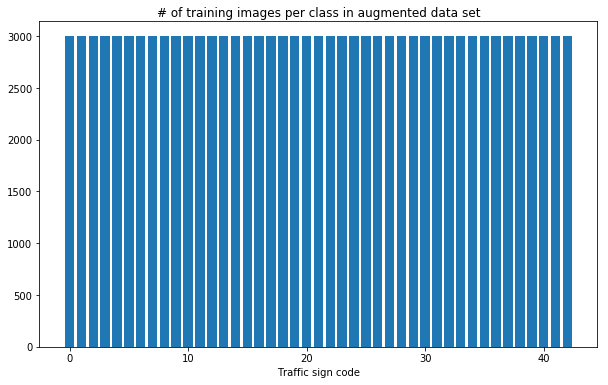

In [11]:
bal_class_id, bal_class_size = np.unique(y_train_bal, return_counts=True)

fig, ax = plt.subplots(figsize=(10,6))
# sns.countplot(y_train_bal)
plt.bar(bal_class_id, bal_class_size, align='center')
plt.title('# of training images per class in augmented data set')
plt.xlabel('Traffic sign code');

# plt.figure(figsize=(60,30))
# class_id, class_size = np.unique(y_train_bal, return_counts=True)
# plt.bar(class_id,class_size,align='center')
# plt.title('Distribution after augmentation')

## Check if labels are still correct after data augmentation

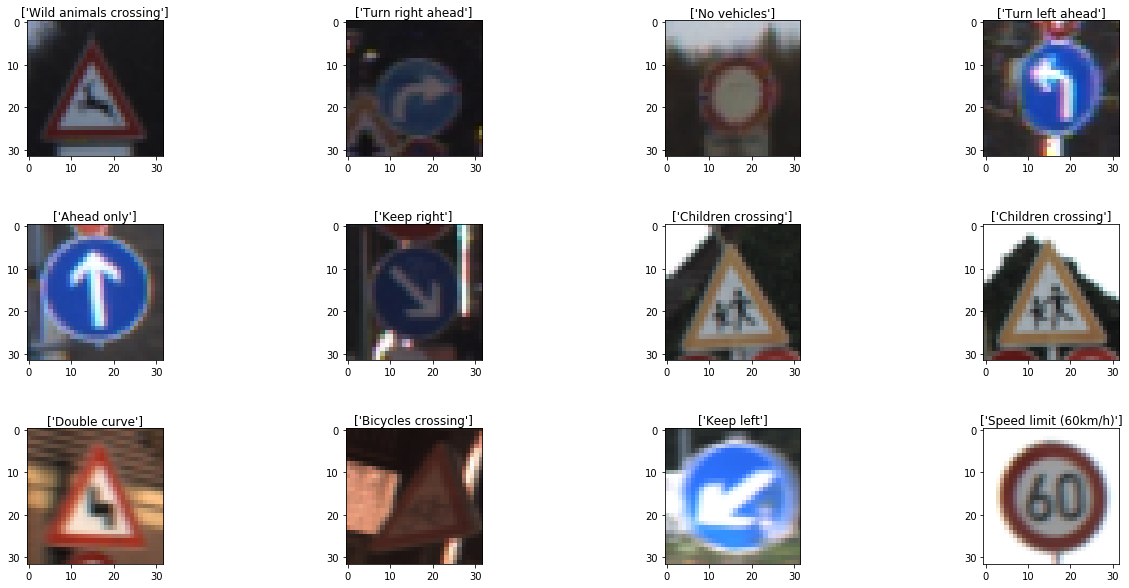

In [12]:
rand_inds = np.random.randint(0,len(X_train_bal),size=(1,12))

num_rows = 3
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,10))
fig.subplots_adjust(hspace=.5,wspace=1)
axs = axs.ravel()

for i in range(num_rows*num_cols):
    axs[i].imshow(X_train_bal[rand_inds[0][i]])
    sign_str = str(y_train_bal[rand_inds[0][i]])
    axs[i].title.set_text(map_dict[sign_str])

## Define transformation functions

In [13]:
def translate(image, pixels=2): # value taken from "lecun-paper"
    tx = np.random.randint(-pixels, pixels+1)
    ty = np.random.randint(-pixels, pixels+1)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(image, M, (32, 32))

def scale(image, scale_val=.1): # value taken from "lecun-paper"
    # rotation functions used for scaling
    factor = 1 + (np.random.rand()-.5)*scale_val
    M = cv2.getRotationMatrix2D((16,16),0,factor)
    return cv2.warpAffine(image, M, (32,32))

def rotate(image, angle=15): # angle taken from "lecun-paper"
    angle = np.random.uniform(-angle, angle)
    M = cv2.getRotationMatrix2D((16, 16), angle, 1)
    return cv2.warpAffine(src=image, M=M, dsize=(32, 32))

# apply all transforms
def transform(image):
    image = translate(image)
    image = scale(image)
    image = rotate(image)
    return image

## Test transformations

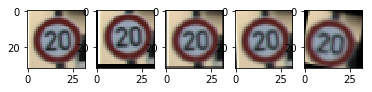

In [14]:
test_img = X_train_bal[0]

transforms = np.zeros((5,32,32,3),dtype=np.uint8)
transforms[0] = test_img
transforms[1] = translate(test_img)
transforms[2] = scale(test_img)
transforms[3] = rotate(test_img)
transforms[4] = transform(test_img)

fig, axs = plt.subplots(1,5)
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(transforms[i])

#     axs[i].title.set_text(map_dict[sign_str])

## Transform fraction of all test images

In [15]:
X_train_aug = np.copy(X_train_bal)
y_train_aug = np.copy(y_train_bal)

trans_perc = 1
for i in range(int(len(X_train_bal)*trans_perc)):
    # find random image
    rand_idx = rand.randint(len(X_train_aug))
    # replace image by transformed one
    X_train_aug[rand_idx] = transform(X_train_aug[rand_idx])

## Bypass transformation if required

In [16]:
# X_train_aug = np.copy(X_train)
# y_train_aug = np.copy(y_train)

## Plot random images from augmented data set to check if label is correct

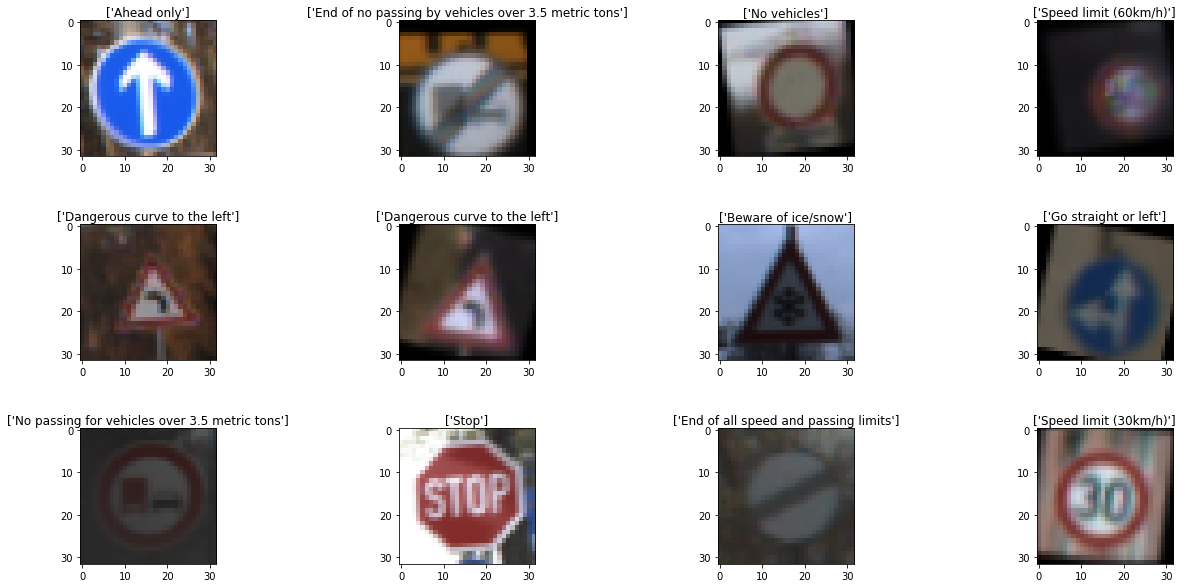

In [17]:
rand_inds = np.random.randint(0,len(X_train_aug),size=(1,12))

num_rows = 3
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,10))
fig.subplots_adjust(hspace=.5,wspace=1)
axs = axs.ravel()

for i in range(num_rows*num_cols):
    axs[i].imshow(X_train_aug[rand_inds[0][i]])
    sign_str = str(y_train_aug[rand_inds[0][i]])
    axs[i].title.set_text(map_dict[sign_str])

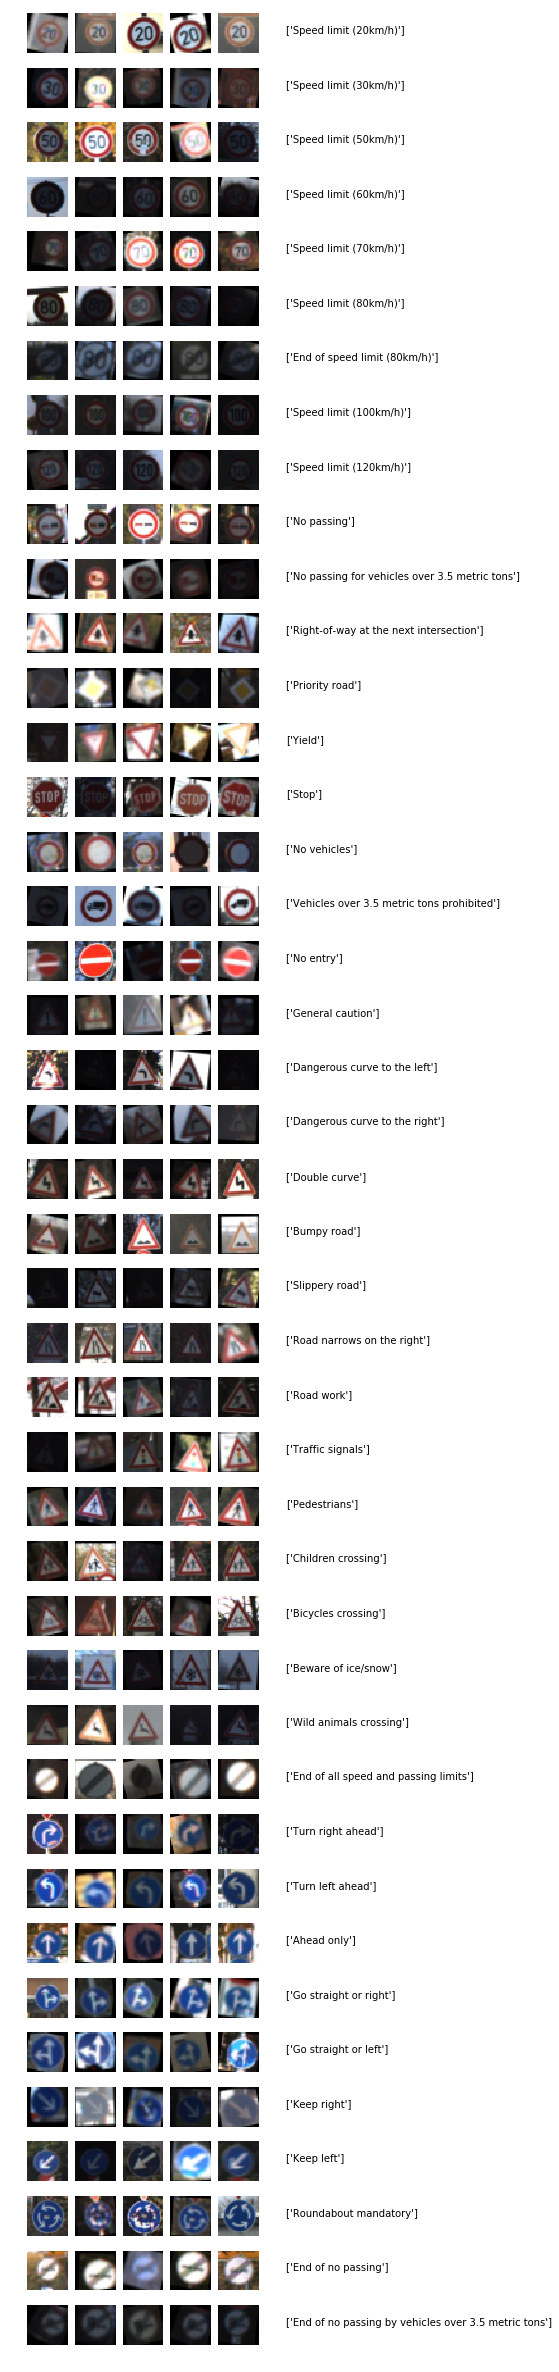

In [18]:
if explore_data:
    n_rows = n_classes
    n_cols = 5

    number_of_images = n_rows*n_cols
    figure, axis = plt.subplots(n_rows, n_cols+1, figsize=(5, 43))
    # figure.subplots_adjust(hspace = 1, wspace = .1)

    for i_row in range(n_rows):    
        idx_spc = np.where(y_train_aug==i_row)
        for i_col in range(n_cols):
            idx = np.random.choice(idx_spc[0])
            image = X_train_aug[idx,:,:,:]
            axis[i_row,i_col].axis('off')
            axis[i_row,i_col].imshow(image)
            if i_col==n_cols-1:
                axis[i_row,i_col+1].axis('off')
                axis[i_row,i_col+1].text(.5,.5,map_dict[str(i_row)],ha='left')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [19]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

Shuffle data to avoid overfitting

In [20]:
from sklearn.utils import shuffle

# X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
X_train_aug, y_train_aug = shuffle(X_train, y_train)

### Grayscale conversion and normalization

Grayscale [OpenCV documentation](https://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html)

#### Function definitions

In [21]:
def x2gray(imgs,col_spc):
    if col_spc=='rgb':
        r_ch = imgs[:,:,:,0]
        g_ch = imgs[:,:,:,1]
        b_ch = imgs[:,:,:,2]
        imgs_gray = 0.299*r_ch + 0.587*g_ch + 0.114*b_ch
        return imgs_gray[:,:,:,np.newaxis]
    if col_spc=='bgr':
        b_ch = imgs[:,:,0]
        g_ch = imgs[:,:,1]
        r_ch = imgs[:,:,2]
        imgs_gray = 0.299*r_ch + 0.587*g_ch + 0.114*b_ch
        return imgs_gray

def norm_img(imgs):
    return np.add(imgs, -128)/128

def preprocess(imgs, col_spc):
    '''Function to preprocess images.
    Input: Color images, color space (string 'rgb' or 'bgr').
    Output: preprocessed images.'''
    imgs = norm_img(imgs)
    imgs = x2gray(imgs, col_spc)
    return imgs

#### Function application

In [22]:
X_train_pre = preprocess(X_train_aug,'rgb')
X_valid_pre = preprocess(X_valid,'rgb')
X_test_pre = preprocess(X_test,'rgb')

In [23]:
print('Shape before and after grayscale conversion:\n {}, {}\n {}, {}\n {}, {}'
        .format(X_train_aug.shape, X_train_pre.shape, 
             X_valid.shape, X_valid_pre.shape,
             X_test.shape, X_test_pre.shape))

print('Min and max values of preprocessed images:\n {}\n {}\n {}\n'
      .format((np.min(X_train_pre), np.max(X_train_pre)),
             (np.min(X_valid_pre), np.max(X_valid_pre)),
             (np.min(X_test_pre), np.max(X_test_pre))))

Shape before and after grayscale conversion:
 (34799, 32, 32, 3), (34799, 32, 32, 1)
 (4410, 32, 32, 3), (4410, 32, 32, 1)
 (12630, 32, 32, 3), (12630, 32, 32, 1)
Min and max values of preprocessed images:
 (-0.9733359374999999, 0.9921874999999999)
 (-0.9646328125, 0.9921874999999999)
 (-0.9716406249999999, 0.9921874999999999)



## Bypass preproccessing if required

In [24]:
# X_train_pre = np.copy(X_train_aug)
# X_valid_pre = np.copy(X_valid)
# X_test_pre = np.copy(X_test)

## Plot some random preprocessed images

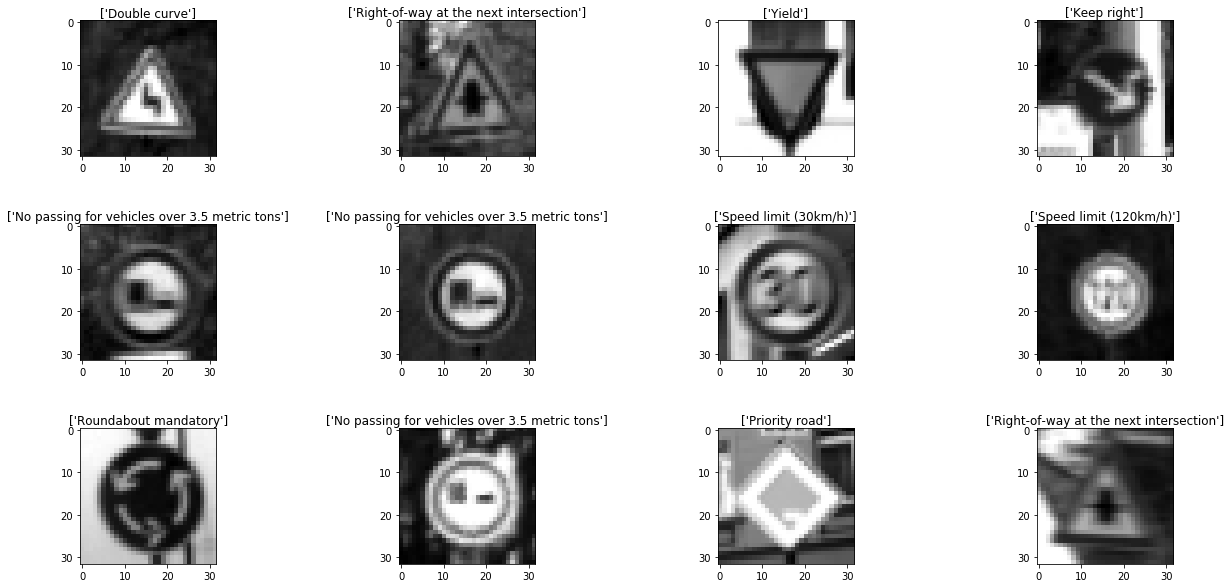

In [25]:
rand_inds = np.random.randint(0,len(X_train_pre),size=(1,12))

num_rows = 3
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,10))
fig.subplots_adjust(hspace=.5,wspace=1)
axs = axs.ravel()

for i in range(num_rows*num_cols):
    axs[i].imshow(X_train_pre[rand_inds[0][i],:,:,0],cmap='gray')
    sign_str = str(y_train_aug[rand_inds[0][i]])
    axs[i].title.set_text(map_dict[sign_str])

## Model Architecture

In [26]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [60]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 12), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    print('shape layer1 before booling (expected: 28x28x6): ',conv1.shape)
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
#     conv1 = tf.nn.dropout(conv1, rate=.5)
    print('shape layer1 (expected: 14x14x6): ', conv1.shape)
    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 25), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(25))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print('shape layer2 (expected: 5x5x16): ', conv2.shape)
#     conv2 = tf.nn.dropout(conv2, rate=.5)
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    print('shape layer2, flat (expected: 400): ', fc0.shape)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(625, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate=.5)
    print('shape layer3 (expected: 120): ', fc1.shape)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc11_W = tf.Variable(tf.truncated_normal(shape=(400, 256), mean = mu, stddev = sigma))
    fc11_b = tf.Variable(tf.zeros(256))
    fc11   = tf.matmul(fc1, fc11_W) + fc11_b
    # SOLUTION: Activation.
    fc11    = tf.nn.relu(fc11)
    fc11 = tf.nn.dropout(fc11, rate=.5)
    print('shape layer3 (expected: 120): ', fc11.shape)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc2    = tf.matmul(fc11, fc2_W) + fc2_b
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, rate=.5)
    print('shape layer4 (expected: 84): ', fc2.shape)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    print('shape layer5 (expected: 43): ', logits.shape)
    
    return logits, conv1, conv2

x and y are placeholders for batches

In [61]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training

In [62]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [63]:
tf.test.is_gpu_available()

True

In [64]:
tf.test.is_built_with_cuda()

True

In [65]:
tf.test.gpu_device_name()

'/device:GPU:0'

### Training pipeline

In [66]:
EPOCHS = 200
BATCH_SIZE = 128
rate = 0.001

# input is passed to LeNet function to calculate logits
logits, conv1, conv2 = LeNet(x)
# compare logits to ground truth labels and calculate cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# averages cross entropy from all training images
loss_operation = tf.reduce_mean(cross_entropy)
# initialize optimizer (Adam algorithm is similar to but more sofisticated than stochastic gradient descent)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# backprob is used here
training_operation = optimizer.minimize(loss_operation)

shape layer1 before booling (expected: 28x28x6):  (?, 28, 28, 12)
shape layer1 (expected: 14x14x6):  (?, 14, 14, 12)
shape layer2 (expected: 5x5x16):  (?, 5, 5, 25)
shape layer2, flat (expected: 400):  (?, 625)
shape layer3 (expected: 120):  (?, 400)
shape layer3 (expected: 120):  (?, 256)
shape layer4 (expected: 84):  (?, 128)
shape layer5 (expected: 43):  (?, 43)


Model Evaluation

In [67]:
# with tf.Session() as sess:
#     test = tf.argmax([[1,2,3,100,1,3,4],[100,2,3,1,2,3,4]],1)
#     sess.run(test)
#     test = tf.Print(test, [test], message='test_abc')
#     test.eval()

In [68]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Model Training

Training...


EPOCH 1 :  train_acc = 0.540 , valid_acc = 0.497 (max)
EPOCH 2 :  train_acc = 0.789 , valid_acc = 0.735 (max)
EPOCH 3 :  train_acc = 0.875 , valid_acc = 0.817 (max)
EPOCH 4 :  train_acc = 0.912 , valid_acc = 0.856 (max)
EPOCH 5 :  train_acc = 0.931 , valid_acc = 0.871 (max)
EPOCH 6 :  train_acc = 0.945 , valid_acc = 0.891 (max)
EPOCH 7 :  train_acc = 0.959 , valid_acc = 0.898 (max)
EPOCH 8 :  train_acc = 0.960 , valid_acc = 0.904 (max)
EPOCH 9 :  train_acc = 0.971 , valid_acc = 0.922 (max)
EPOCH 10 :  train_acc = 0.971 , valid_acc = 0.914 
EPOCH 11 :  train_acc = 0.975 , valid_acc = 0.922 (max)
EPOCH 12 :  train_acc = 0.977 , valid_acc = 0.910 
EPOCH 13 :  train_acc = 0.982 , valid_acc = 0.932 (max)
EPOCH 14 :  train_acc = 0.982 , valid_acc = 0.928 
EPOCH 15 :  train_acc = 0.981 , valid_acc = 0.932 (max)
EPOCH 16 :  train_acc = 0.982 , valid_acc = 0.928 
EPOCH 17 :  train_acc = 0.983 , valid_acc = 0.935 (max)
EPOCH 18 :  train_acc = 0.983 , valid_acc = 0.929 
EPOCH 19 :  

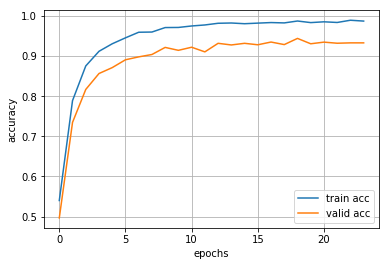

In [69]:
from tqdm import tqdm
import time

try:
    saver
except NameError:
    saver = tf.train.Saver()

max_acc = 0
max_acc_epoch = 0

# start time measurement
time_start = time.time()

acc_df = pd.DataFrame({'epoch': [], 'train acc': [], 'valid acc': []})
# accuracy_course = np.zeros(2,EPOCHS)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_pre)

    print("Training...")
    print()
    
    for i in range(EPOCHS):
        
        X_train_pre, y_train_aug = shuffle(X_train_pre, y_train_aug)
#         for offset in tqdm(range(0, num_examples, BATCH_SIZE)): # includes tqdm progess meter
        for offset in range(0, num_examples, BATCH_SIZE): #without tqdm progress meter     
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_pre[offset:end], y_train_aug[offset:end]
            # training
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                
        train_accuracy = evaluate(X_train_pre, y_train_aug)
        #         accuracy_course[0,i] = train_accuracy
        valid_accuracy = evaluate(X_valid_pre, y_valid)
        #         accuracy_course[1,i] = valid_accuracy

        print("\nEPOCH {}".format(i+1), ": ", 
              "train_acc = {:.3f}".format(train_accuracy), ", "
              "valid_acc = {:.3f}".format(valid_accuracy),end=" ")

        acc_df = acc_df.append({'epoch': i, 
                       'train acc': train_accuracy, 'valid acc': valid_accuracy}, 
                      ignore_index=True)
        
        if valid_accuracy > max_acc:
            max_acc_epoch, max_acc = i, valid_accuracy
            saver.save(sess, './lenet.ckpt')
            print('(max)',end="")
        elif i - max_acc_epoch >= 5:
            print('Stopping after 5 epochs without improvement.')
            break
        
#     try:
#         saver
#     except NameError:
#         saver = tf.train.Saver()
#     saver.save(sess, './lenet')
#     print("Model saved")

    acc_df['train acc'].plot(legend=True)
    ax = acc_df['valid acc'].plot(grid=True,legend=True)
    ax.set_xlabel('epochs')
    ax.set_ylabel('accuracy');
    
# stop time measurement and print result
time_end = time.time()
print('Training time: ', np.round(time_end-time_start,2), 's')

In [70]:
#stop here

In [71]:
# run this cell only once!

# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('.'))

#     test_accuracy = evaluate(X_test_pre, y_test)
#     print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [72]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Read and plot example image

(32, 32, 3)
0 255


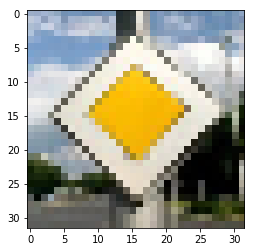

(32, 32)
-0.9999999999999999 0.976390625


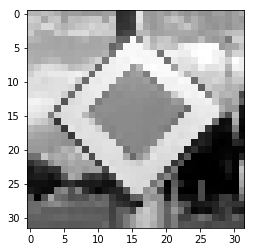

In [73]:
test = cv2.cvtColor(cv2.imread('./traffic_sign_images/vz02.jpeg'),cv2.COLOR_BGR2RGB)
test = cv2.resize(test, (32,32))
print(test.shape)
print(np.min(test), np.max(test))
plt.imshow(test); plt.show()
test_pre = preprocess(test,'bgr')
print(test_pre.shape)
print(np.min(test_pre), np.max(test_pre))
plt.imshow(test_pre,cmap='gray');

### Read and preprocess all new images

In [74]:
X_new_test = []
path = './traffic_sign_images/'

for img_name in os.listdir(path):
    img = cv2.imread(path+img_name)
    img = cv2.resize(img, (32,32))
    img = preprocess(img,'bgr')
    X_new_test.append(img)


### Plot all example images

(32, 32, 3)


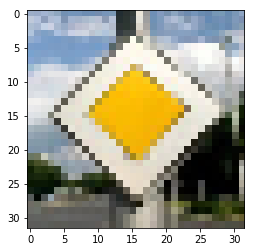

In [75]:
# plt.figure(figsize=(16,9))
# for i in range(len(X_new_test)):
#     plt.subplot(3,6,i+1)
#     plt.imshow(X_new_test[i], cmap='gray')
#     plt.xticks([]); plt.yticks([])
img = cv2.imread(path+'vz02.jpeg')
img = cv2.resize(img, (32,32))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

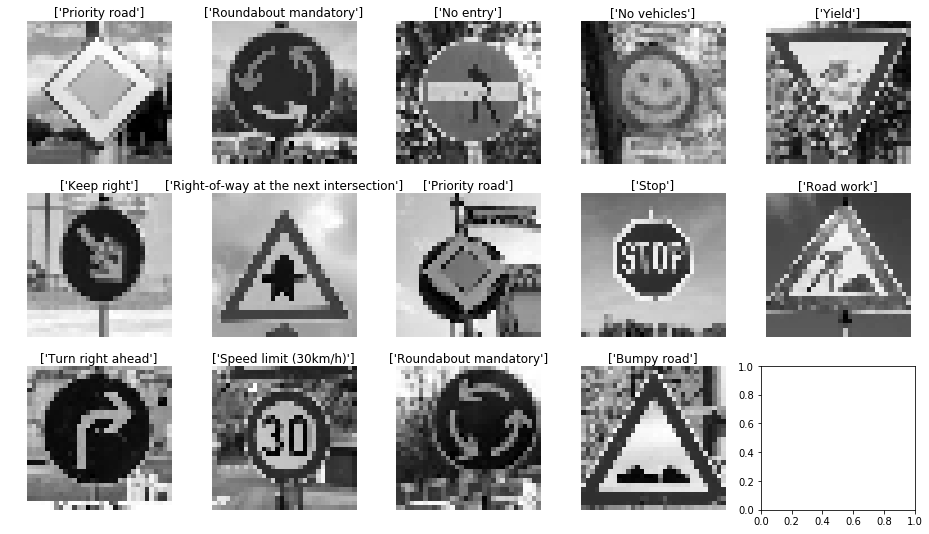

In [76]:
path = './traffic_sign_images/'
img_names = sorted(os.listdir(path))

n_imgs = len(img_names)

y_test_new = np.array([12, 40, 17, 15, 13, 38, 11, 12, 14, 25, 33,  1, 40, 22])[0:n_imgs]

X_test_new = np.zeros([n_imgs, 32, 32, 3], dtype=np.uint8)
X_test_new_pre = np.zeros([n_imgs, 32, 32, 1])

fig, axs = plt.subplots(3,5,figsize=(16,9))
axs = axs.ravel()

for idx, img_name in enumerate(img_names[0:n_imgs]):
    if img_name.endswith('.jpeg'):
        img = cv2.imread(path+img_name)
        img = cv2.resize(img, (32,32))
        X_test_new[idx] = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = preprocess(img,'bgr')
        X_test_new_pre[idx,:,:,0] = img
        axs[idx].imshow(X_test_new_pre[idx,:,:,0],cmap='gray')
        axs[idx].set_title(map_dict[str(y_test_new[idx])])
        axs[idx].axis('off')

### Predict the Sign Type for Each Image

In [77]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [78]:

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './lenet.ckpt')
#     saver.restore(sess, tf.train.latest_checkpoint('.'))
    y_pred_new = sess.run(tf.argmax(logits, 1), feed_dict={x: X_test_new_pre, y: y_test_new})
    print('Numbers:      ', np.arange(1,n_imgs+1))
    print('----------------------------------------------------------')
    print('Prediction:   ', y_pred_new)
    print('Ground truth: ', y_test_new)

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

2 root error(s) found.
  (0) Not found: Key Variable_12 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-78-b48b6cbcbd42>:2) ]]
  (1) Not found: Key Variable_12 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-78-b48b6cbcbd42>:2) ]]
	 [[save_2/RestoreV2/_105]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'save_2/RestoreV2':
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-b48b6cbcbd42>", line 2, in <module>
    saver = tf.train.Saver()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 825, in __init__
    self.build()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 837, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 875, in _build
    build_restore=build_restore)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 328, in _AddRestoreOps
    restore_sequentially)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [ ]:
with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
        saver.restore(sess, './lenet.ckpt')
        new_test_accuracy = evaluate(X_test_new_pre, y_test_new)
        print("Test Accuracy (new images) = {:.3f}".format(new_test_accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [79]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [80]:
with tf.Session() as sess:
#         saver = tf.train.Saver()
    saver.restore(sess, './lenet.ckpt')
    y_prob_new, y_pred_new = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), 
                                      feed_dict={x: X_test_new_pre, y: y_test_new})
    plt.barh(np.arange(len(y_prob_new[0])), y_prob_new[0], align='center')

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

2 root error(s) found.
  (0) Not found: Key Variable_12 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-78-b48b6cbcbd42>:2) ]]
  (1) Not found: Key Variable_12 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-78-b48b6cbcbd42>:2) ]]
	 [[save_2/RestoreV2/_127]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'save_2/RestoreV2':
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-b48b6cbcbd42>", line 2, in <module>
    saver = tf.train.Saver()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 825, in __init__
    self.build()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 837, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 875, in _build
    build_restore=build_restore)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 328, in _AddRestoreOps
    restore_sequentially)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
fig, axs = plt.subplots(n_imgs, 2, figsize=(20,30))
axs = np.ravel(axs)

for i in range(n_imgs):
    axs[2*i].imshow(X_test_new[i])
    axs[2*i+1].barh(np.arange(len(y_prob_new[0])), y_prob_new[i], align='center')
    pred_labels = [map_dict[str(j)] for j in y_pred_new[i]]
    axs[2*i+1].set_xlim([0,1])
    axs[2*i+1].set_yticks(np.arange(0,len(pred_labels),1))
    axs[2*i+1].set_yticklabels(pred_labels)
    
#     if i%2==0:
#         axs[i].imshow(X_test_new[i])
#     elif i%2!=0:
#         axs[i].barh(np.arange(len(top_k[0][0])), top_k[0][i], align='center')

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [81]:
# ### Visualize your network's feature maps here.
# ### Feel free to use as many code cells as needed.

# # image_input: the test image being fed into the network to produce the feature maps
# # tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# # activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# # plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

# def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
#     # Here make sure to preprocess your image_input in a way your network expects
#     # with size, normalization, ect if needed
#     # image_input =
#     # Note: x should be the same name as your network's tensorflow data placeholder variable
#     # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
#     activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
#     featuremaps = activation.shape[3]
#     plt.figure(plt_num, figsize=(15,15))
#     for featuremap in range(featuremaps):
#         plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
#         plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
#         if activation_min != -1 & activation_max != -1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
#         elif activation_max != -1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
#         elif activation_min !=-1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
#         else:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [82]:

# ### Visualize your network's feature maps here.
# ### Feel free to use as many code cells as needed.

# # image_input: the test image being fed into the network to produce the feature maps
# # tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# # activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# # plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

# def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
#     # Here make sure to preprocess your image_input in a way your network expects
#     # with size, normalization, ect if needed
#     # image_input =
#     # Note: x should be the same name as your network's tensorflow data placeholder variable
#     # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
#     activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
#     featuremaps = activation.shape[3]
#     plt.figure(plt_num, figsize=(15,15))
#     for featuremap in range(featuremaps):
#         plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
#         plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
#         if activation_min != -1 & activation_max != -1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
#         elif activation_max != -1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
#         elif activation_min !=-1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
#         else:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('.'))
#     ix = int(np.random.random() * x_test_n.shape[0])
#     random_image = np.expand_dims(x_test_n[ix], axis=0)
#     print('Feature maps for', signnames[y_test[ix]])
#     plt.imshow(x_test[ix])
#     plt.show()
#     print('First convolutional layer')
#     outputFeatureMap(random_image, conv1, plt_num=1)
#     print('Second convolutional layer')
#     outputFeatureMap(random_image, conv2, plt_num=2)

In [83]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# Note: that to get access to tf_activation, the session should be interactive which can be achieved with the following commands.
# sess = tf.InteractiveSession()
# sess.as_default()

# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and    max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [84]:
with tf.Session() as sess:    
    saver.restore(sess, './lenet.ckpt')
#     saver.restore(sess, tf.train.latest_checkpoint('.'))#'./lenet')
    plt.imshow(X_test_new_pre[8,:,:,0], cmap='gray')
    plt.show()
    outputFeatureMap(X_test_pre[0].reshape(1,32,32,1), conv1)
    

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

2 root error(s) found.
  (0) Not found: Key Variable_12 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-78-b48b6cbcbd42>:2) ]]
  (1) Not found: Key Variable_12 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-78-b48b6cbcbd42>:2) ]]
	 [[save_2/RestoreV2/_31]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'save_2/RestoreV2':
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-b48b6cbcbd42>", line 2, in <module>
    saver = tf.train.Saver()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 825, in __init__
    self.build()
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 837, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 875, in _build
    build_restore=build_restore)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 328, in _AddRestoreOps
    restore_sequentially)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
